# Accessibilité relative des résidus et évolution protéique

Il y a plusieurs étapes dans le traitement des données :

 * obtenir les données pdb par **PISCES**
 * faire tourner **DSSP** pour obtenir l'accessibilité du solvant
 * récupération des séquences homologues par **PSI-BLAST** (pas moins de 70% d'identité)
 * réalignement avec la séquence parente
 * repositionnement des chaines latérales avec **SCWRL4** -> accessibilité du solvant ? 

## PISCES

Sélection de la base de données la plus petite base de [données](http://dunbrack.fccc.edu/Guoli/culledpdb_hh/cullpdb_pc20_res1.6_R0.25_d201103_chains3760.gz)

Pour récupérer les fichiers PDB par ligne de commande simplement faire :  
`wget https://files.rcsb.org/download/XXXX.pdb`  
Le fichier pdb se créera dans le dossier sous le nom XXXX.pdb avec XXXX l'ID de la protéine.

In [30]:
def pdbfiles(pisces_file):
    """Creates list of [pdb id, chain, length]
    """
    with open(pisces_file, 'r') as file:
        pdb_list = []
        next(file)
        for line in file:
            line = line.split()
            pdb_list.append([line[0][0:4], line[0][4:], int(line[1])])
        return pdb_list

In [31]:
PDB = pdbfiles('../../cullpdb_pc20_res1.6_R0.25_d201103_chains3760')

On récupère ainsi une liste contenant pour chaque protéine une liste de son identifiant, la chaine choisie et sa taille.

## DSSP

In [4]:
import wget

pdbfiles = wget.download('https://files.rcsb.org/download/1AHO.pdb', out = '../data/1AHO.pdb')
pdbfiles = wget.download('https://files.rcsb.org/download/1BTE.pdb', out = '../data/1BTE.pdb')

## 1AHO 

### Traitement de 1AHO

In [1]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

p = PDBParser()
structure = p.get_structure("1AHO","../data/1AHO.pdb")
model = structure[0]
DSSP = DSSP(model, "../data/1AHO.pdb")

In [2]:
def full_structure(DSSP_dict):
    """ Check si certains acides aminés n'ont pas de structure secondaire associés
    """
    for key in DSSP_dict.keys():
        if DSSP_dict[key][2] == '-':
            return False
    return True

In [34]:
print(full_structure(DSSP)) #si False -> certains AA n'ont pas de structure secondaire predites

False


In [3]:
ASA_1AHO = []
fasta_1AHO = []
for key in DSSP.keys():
    #print(DSSP[key])
    ASA_1AHO.append(DSSP[key][3])
    fasta_1AHO.append(DSSP[key][1])

### Traitement de 4AEI

In [4]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

p = PDBParser()
structure = p.get_structure("4AEI","../data/4AEI.pdb")
model = structure[0]
DSSP = DSSP(model, "../data/4AEI.pdb")

ASA_4AEI = []
fasta_4AEI = []
for key in DSSP.keys():
    ASA_4AEI.append(DSSP[key][3])
    fasta_4AEI.append(DSSP[key][1])
# warning is okay

/home/epsilon/miniconda3/envs/projet-tut/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2262.
  warnings.warn(


### Traitement 1SEG

In [5]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

p = PDBParser()
structure = p.get_structure("1SEG","../data/1SEG.pdb")
model = structure[0]
DSSP = DSSP(model, "../data/1SEG.pdb")

ASA_1SEG = []
fasta_1SEG = []
for key in DSSP.keys():
    ASA_1SEG.append(DSSP[key][3])
    fasta_1SEG.append(DSSP[key][1])

### Traitement de 2KBH

In [6]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

p = PDBParser()
structure = p.get_structure("2KBH","../data/2KBH.pdb")
model = structure[0]
DSSP = DSSP(model, "../data/2KBH.pdb")

ASA_2KBH = []
fasta_2KBH = []
for key in DSSP.keys():
    ASA_2KBH.append(DSSP[key][3])
    fasta_2KBH.append(DSSP[key][1])

### Traitement des données

In [7]:
import numpy as np

#2KBH not taken into account since its size differs
data_1AHO = np.array([ASA_1AHO, ASA_4AEI, ASA_1SEG])
average_1AHO = np.mean(data_1AHO, axis = 0)
#print(average_1AHO)

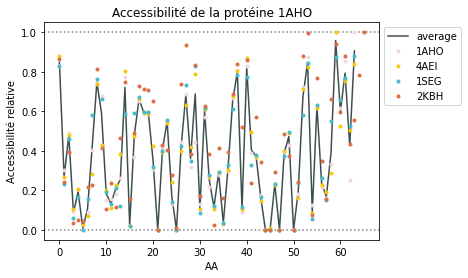

In [14]:
import matplotlib.pyplot as plt

plt.axhline(y=1, color='grey', linestyle=':')
plt.axhline(y=0, color='grey', linestyle=':')

plt.plot(average_1AHO, label="average", color="#3e4e50")
plt.plot(ASA_1AHO,'.', label="1AHO", color="#f3d9dc")
plt.plot(ASA_4AEI, '.', label="4AEI", color="#f9c80e")
plt.plot(ASA_1SEG, '.', label="1SEG", color="#43bccd")
plt.plot(ASA_2KBH, '.', label="2KBH", color="#dd6e42")

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Accessibilité de la protéine 1AHO")
plt.xlabel("AA")
plt.ylabel("Accessibilité relative")

plt.savefig('ASA_1AHO+2KBH.jpeg', dpi=500, bbox_inches="tight")
plt.show()
#if error with first run, works well with second run

## 1BTE

### Traitement de 1BTE

In [51]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

p = PDBParser()
structure = p.get_structure("1BTE","../data/1BTE.pdb")
model = structure[0]
DSSP = DSSP(model, "../data/1BTE.pdb")

ASA_1BTE = []
fasta_1BTE = []
for key in DSSP.keys():
    #print(DSSP[key])
    ASA_1BTE.append(DSSP[key][3])
    fasta_1BTE.append(DSSP[key][1])

### Traitement de 1LX5

In [16]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

p = PDBParser()
structure = p.get_structure("1LX5","../data/1LX5.pdb")
model = structure[0]
DSSP = DSSP(model, "../data/1LX5.pdb")

ASA_1LX5 = []
fasta_1LX5 = []
for key in DSSP.keys():
    ASA_1LX5.append(DSSP[key][3])
    fasta_1LX5.append(DSSP[key][1])
# warning is okay

/home/epsilon/miniconda3/envs/projet-tut/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1524.
  warnings.warn(


### Traitement de 5NH3

In [17]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

p = PDBParser()
structure = p.get_structure("5NH3","../data/5NH3.pdb")
model = structure[0]
DSSP = DSSP(model, "../data/5NH3.pdb")

ASA_5NH3 = []
fasta_5NH3 = []
for key in DSSP.keys():
    ASA_5NH3.append(DSSP[key][3])
    fasta_5NH3.append(DSSP[key][1])

### Traitement des données

In [48]:
ASA_1BTE_modif = [None] + ASA_1BTE[:27] + [None, None, None, None] + ASA_1BTE[27:]
ASA_1LX5_modif = [None] + ASA_1LX5

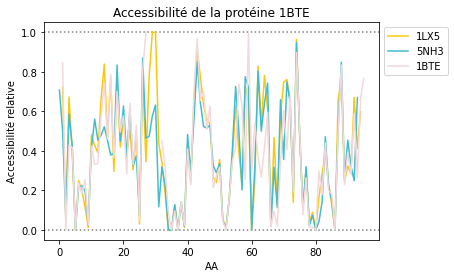

In [49]:
import matplotlib.pyplot as plt

plt.axhline(y=1, color='grey', linestyle=':')
plt.axhline(y=0, color='grey', linestyle=':')

#plt.plot(average_1AHO, label="average", color="#3e4e50")
plt.plot(ASA_1LX5_modif, label="1LX5", color="#f9c80e")
plt.plot(ASA_5NH3, label="5NH3", color="#43bccd")
plt.plot(ASA_1BTE_modif, label="1BTE", color="#f3d9dc")

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Accessibilité de la protéine 1BTE")
plt.xlabel("AA")
plt.ylabel("Accessibilité relative")

plt.savefig('ASA_1BTE.jpeg', dpi=500, bbox_inches="tight")
plt.show()
#if error with first run, works well with second run